In [17]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
%%R

# My commonly used R imports

require('tidyverse')
require('tidycensus')

In [20]:
%%R 

census_api_key("a85718b5c3280ae541fa313692500b2e711dee25")

To install your API key for use in future sessions, run this function with `install = TRUE`.


In [21]:
%%R
# Load the data from merged_rent.csv
df <- read_csv("merged_rent.csv")

New names:
• `` -> `...1`
Rows: 1178 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): NAME, BOROUGH, geometry, race
dbl (16): ...1, GEOID, eviction_19, eviction_23, population_renter, median_r...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
%%R
tenant_23 <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population_renter = "B25008_003"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=T)

Getting data from the 2018-2022 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [24]:
%%R
tenant_19 <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population_renter = "B25008_003"
                      ), 
                      year = 2018,
                      survey="acs5",
                      geometry=T)

  |======================================================================| 100%


Getting data from the 2014-2018 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [27]:
%%R
# rename "estimate" column in tenant_19 to "tenant_19"
tenant_19 <- tenant_19 %>% rename(tenant_19 = estimate)
tenant_23 <- tenant_23 %>% rename(tenant_23 = estimate)
head(tenant_19)

Simple feature collection with 6 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -73.88799 ymin: 40.70717 xmax: -73.74934 ymax: 40.89182
Geodetic CRS:  NAD83
        GEOID                                         NAME          variable
1 36081046200    Census Tract 462, Queens County, New York population_renter
2 36081048100    Census Tract 481, Queens County, New York population_renter
3 36081049600    Census Tract 496, Queens County, New York population_renter
4 36081050202 Census Tract 502.02, Queens County, New York population_renter
5 36005040400     Census Tract 404, Bronx County, New York population_renter
6 36005040800     Census Tract 408, Bronx County, New York population_renter
  tenant_19 moe                       geometry
1      5179 888 MULTIPOLYGON (((-73.79203 4...
2      5095 714 MULTIPOLYGON (((-73.88799 4...
3       602 183 MULTIPOLYGON (((-73.75726 4...
4       286 162 MULTIPOLYGON (((-73.76255 4...
5      1319 403 MULTIPOLYGO

In [31]:
%%R
# drop the "moe","geometry","variable" column
tenant_19 <- tenant_19 %>% select(-moe, -geometry, -variable)
tenant_23 <- tenant_23 %>% select(-moe, -geometry, -variable)

In [34]:
%%R
# merge tenant_19 and tenant_23
df1 <- as.data.frame(tenant_19)
df2 <- as.data.frame(tenant_23)
tenant <- merge(df1, df2, by="GEOID")

In [36]:
%%R
# drop "geometry.x" and "geometry.y""NAME.y" column
# rename "NAME.x" to "NAME"
tenant <- tenant %>% select(-geometry.x, -geometry.y, -NAME.y)  %>% rename(NAME = NAME.x)

In [37]:
%%R
head(tenant)

        GEOID                                    NAME tenant_19 tenant_23
1 36005000100  Census Tract 1, Bronx County, New York         0         0
2 36005000200  Census Tract 2, Bronx County, New York      2344      1570
3 36005000400  Census Tract 4, Bronx County, New York      1217      2050
4 36005001600 Census Tract 16, Bronx County, New York      4814      4723
5 36005002300 Census Tract 23, Bronx County, New York      4595      4523
6 36005002400 Census Tract 24, Bronx County, New York       172         0


In [39]:
%%R
# merge tenant with df, by "NAME"
df <- merge(df, tenant, by="NAME")

In [40]:
%%R
# "eviction_rate_19" = "eviction_19" / "tenant_19"
df$eviction_rate_19 <- df$eviction_19 / df$tenant_19
df$eviction_rate_23 <- df$eviction_23 / df$tenant_23

In [42]:
%%R
# write df to merged_rent_2.csv, get rid of row names
write_csv(df, "merged_rent_2.csv")

`geom_smooth()` using formula = 'y ~ x'


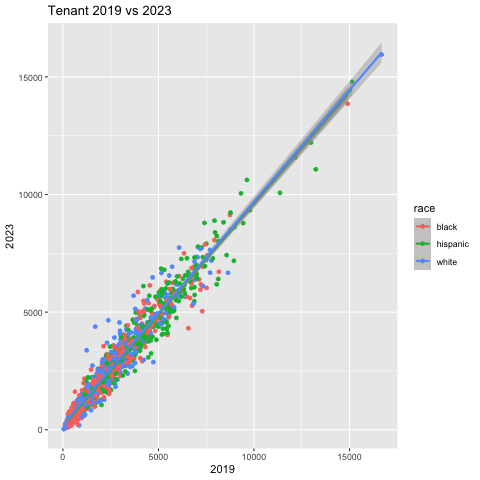

In [46]:
%%R
# plot tenant_19 by tenant_23
df %>%
    ggplot(aes(x=tenant_19, y=tenant_23, color=race)) +
    geom_point()+
    geom_smooth(method="lm") +
    labs(title="Tenant 2019 vs 2023", x="2019", y="2023")

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 27 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 27 rows containing missing values or values outside the scale range
(`geom_point()`). 



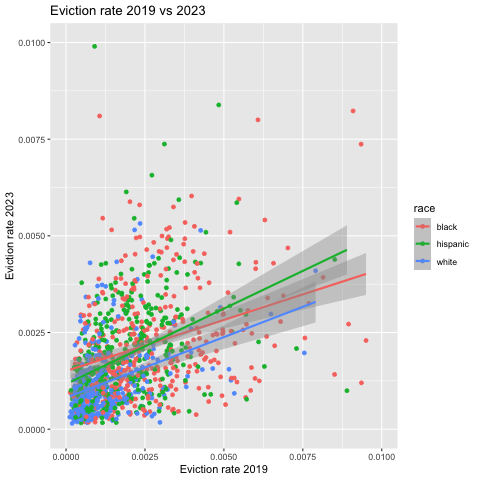

In [47]:
%%R
# plot eviction_rate_19 by eviction_rate_23
df %>%
    ggplot(aes(x=eviction_rate_19, y=eviction_rate_23, color=race)) +
    geom_point()+
    xlim(0, 0.01) +
    ylim(0, 0.01) +
    geom_smooth(method="lm") +
    labs(title="Eviction rate 2019 vs 2023", x="Eviction rate 2019", y="Eviction rate 2023")

In [ ]:
%%R
# read newyork_map.csv
df <- read.csv("newyork_map.csv")
# get the list of id
zipcode_list <- df$id

In [7]:
%%R
nyc_census_data <- get_acs(geography = "zip code tabulation area", 
                      zcta = zipcode_list,
                      variables = c(
                        median_rent = "B25064_001",
                        median_income = "B19013_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

  |======================================================================| 100%


Getting data from the 2017-2021 5-year ACS


In [8]:
%%R
# head
head(nyc_census_data)

Simple feature collection with 6 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -73.9434 ymin: 40.64424 xmax: -73.82641 ymax: 40.82864
Geodetic CRS:  NAD83
  GEOID        NAME      variable estimate  moe                       geometry
1 10037 ZCTA5 10037 median_income    48782 8464 MULTIPOLYGON (((-73.94317 4...
2 10037 ZCTA5 10037   median_rent     1350   97 MULTIPOLYGON (((-73.94317 4...
3 11414 ZCTA5 11414 median_income    86113 9709 MULTIPOLYGON (((-73.86317 4...
4 11414 ZCTA5 11414   median_rent     1748   97 MULTIPOLYGON (((-73.86317 4...
5 10473 ZCTA5 10473 median_income    48212 4600 MULTIPOLYGON (((-73.88441 4...
6 10473 ZCTA5 10473   median_rent     1010   67 MULTIPOLYGON (((-73.88441 4...


In [9]:
%%R
# filter GEOID,NAME,variable in nyc_census_data
census_data <- nyc_census_data %>%
    select(GEOID, variable, estimate)%>%
    #pivot from long to wide
    pivot_wider(
    names_from=variable, 
    values_from = estimate,
    names_glue = "{variable}"
  )

In [10]:
%%R
head(census_data)

Simple feature collection with 6 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.00377 ymin: 40.54374 xmax: -73.80751 ymax: 40.82864
Geodetic CRS:  NAD83
# A tibble: 6 × 4
  GEOID                                       geometry median_income median_rent
  <chr>                             <MULTIPOLYGON [°]>         <dbl>       <dbl>
1 10037 (((-73.94317 40.81094, -73.94225 40.8122, -73…         48782        1350
2 11414 (((-73.86317 40.65828, -73.86036 40.65965, -7…         86113        1748
3 10473 (((-73.88441 40.82297, -73.87993 40.82364, -7…         48212        1010
4 10036 (((-74.00377 40.76356, -74.00135 40.7629, -74…         98177        2196
5 11355 (((-73.83792 40.75454, -73.8338 40.75672, -73…         46963        1525
6 11697 (((-73.94054 40.54404, -73.94013 40.55068, -7…        113047         950


In [11]:
%%R
head(df)

     id month_date month_filings month_rate month_rate_scale_max month_diff
1 10001 01/04/2023           324 0.03336079            0.1272825  0.5330782
2 10002 01/04/2023           569 0.01966613            0.1272825  0.2710843
3 10003 01/04/2023           206 0.01170588            0.1272825  0.4179004
4 10004 01/04/2023            15 0.01358696            0.1272825  0.3809524
5 10005 01/04/2023            90 0.02613240            0.1272825  0.8272727
6 10006 01/04/2023            36 0.02706767            0.1272825  0.7400000
  pct_white  pct_black pct_latinx   race execute_count execute_rate
1 0.5495264 0.07269357 0.12675041  white            64  0.006589786
2 0.2153942 0.09076141 0.27698476 latinx            90  0.003110635
3 0.7551995 0.03454938 0.07239459  white            55  0.003125355
4 0.6811594 0.08605072 0.05525362  white             8  0.007246377
5 0.7955865 0.01132404 0.03745645  white            26  0.007549361
6 0.6368421 0.06090226 0.10902256  white             5  0.00

In [12]:
%%R
# change GEOID to integer
census_data$GEOID <- as.integer(census_data$GEOID)

In [13]:
%%R
# merge census_data and df
df <- left_join(df, census_data, by=c("id"="GEOID"))

In [14]:
%%R
head(df)

     id month_date month_filings month_rate month_rate_scale_max month_diff
1 10001 01/04/2023           324 0.03336079            0.1272825  0.5330782
2 10002 01/04/2023           569 0.01966613            0.1272825  0.2710843
3 10003 01/04/2023           206 0.01170588            0.1272825  0.4179004
4 10004 01/04/2023            15 0.01358696            0.1272825  0.3809524
5 10005 01/04/2023            90 0.02613240            0.1272825  0.8272727
6 10006 01/04/2023            36 0.02706767            0.1272825  0.7400000
  pct_white  pct_black pct_latinx   race execute_count execute_rate
1 0.5495264 0.07269357 0.12675041  white            64  0.006589786
2 0.2153942 0.09076141 0.27698476 latinx            90  0.003110635
3 0.7551995 0.03454938 0.07239459  white            55  0.003125355
4 0.6811594 0.08605072 0.05525362  white             8  0.007246377
5 0.7955865 0.01132404 0.03745645  white            26  0.007549361
6 0.6368421 0.06090226 0.10902256  white             5  0.00

In [15]:
%%R
# write to csv
write.csv(df, "newyork_map.csv", row.names = FALSE)

In [ ]:
%%R
# linear regression, execute_rate/month_rate vs median_rent
model <- lm(I(execute_rate/month_rate) ~ median_income, data = df)
print(summary(model))


Call:
lm(formula = I(execute_rate/month_rate) ~ median_income, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18909 -0.06265 -0.01830  0.04343  0.45594 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.464e-01  1.773e-02   8.256 3.54e-14 ***
median_income 7.628e-07  1.877e-07   4.064 7.29e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1004 on 175 degrees of freedom
  (123 observations deleted due to missingness)
Multiple R-squared:  0.08622,	Adjusted R-squared:  0.081 
F-statistic: 16.51 on 1 and 175 DF,  p-value: 7.288e-05



In [ ]:
%%R
# linear regression, execute_rate/month_rate vs median_rent
model <- lm(month_diff ~ median_income, data = df)
print(summary(model))


Call:
lm(formula = month_diff ~ median_income, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32547 -0.13124 -0.01600  0.06651  1.43596 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.731e-01  3.430e-02  10.877  < 2e-16 ***
median_income 1.543e-06  3.567e-07   4.326 2.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1997 on 188 degrees of freedom
  (110 observations deleted due to missingness)
Multiple R-squared:  0.09053,	Adjusted R-squared:  0.08569 
F-statistic: 18.71 on 1 and 188 DF,  p-value: 2.462e-05



In [ ]:
%%R
# delete column geometry
df <- df %>% select(-geometry)

In [ ]:
%%R
# write to csv
write.csv(df, "newyork_map.csv", row.names = FALSE)

In [ ]:
%%R
# plot execute_rate/month_rate by median_rent
ggplot(df, aes(x=median_income, y=execute_rate/month_rate, color=race)) + geom_point() + geom_smooth(method = "lm")+labs(title="execute_rate/month_rate by median_income")

UsageError: Cell magic `%%R` not found.


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 123 rows containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 2: Removed 123 rows containing missing values or values outside the scale range
(`geom_text()`). 



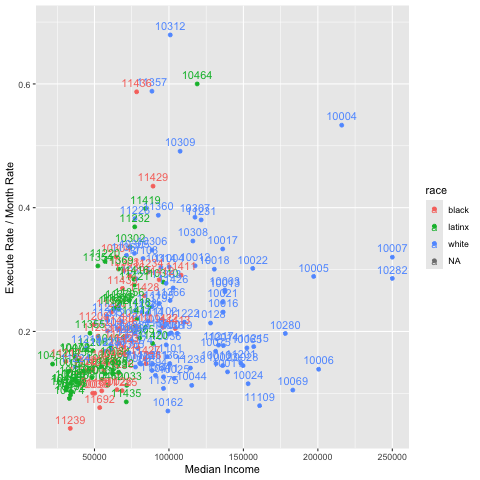

In [ ]:
%%R
ggplot(df, aes(x = median_income, y = execute_rate/month_rate, color=race, label = id)) +
  geom_point() +
  geom_text(nudge_y = 0.015) +
  labs(x = "Median Income", y = "Execute Rate / Month Rate")

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 110 rows containing missing values or values outside the scale range
(`geom_point()`). 



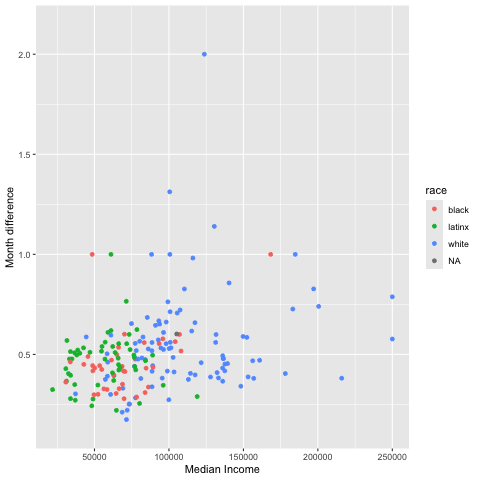

In [ ]:
%%R
ggplot(df, aes(x = median_income, y = month_diff, color=race)) +
  geom_point() +
  labs(x = "Median Income", y = "Month difference")

In [ ]:
%%R
# select id=10471
df %>% filter(id == 10471)

     id month_date month_filings month_rate month_rate_scale_max month_diff
1 10471 01/04/2023           213 0.04741763            0.1272825  0.6096866
  pct_white pct_black pct_latinx  race execute_count execute_rate
1 0.5249332 0.1422529  0.2439893 white            27  0.006010686
                        geometry median_income median_rent
1 MULTIPOLYGON (((-73.92096 4...         96368        1619
